### Demonstração do Quantum Key Distribution

Neste jupyter notebook vamos demonstrar a quantum key distribution usando Qiskit. A esta altura, você já deve estar familiarizado com as etapas básicas do protocolo. Só para lembrar em breve, o objetivo final é ganhar um segredo _partilhado_. Neste caso, será uma chave compartilhada entre Bob e Alice, que pode ser usada para criptografar mensagens. Somente eles poderão conhecer este segredo.

In [1]:
import numpy as np
from numpy import pi

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister, execute
from qiskit.providers.aer import AerSimulator
from qiskit.tools import job_monitor

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

Alice escolherá uma base e um bit aleatório, Bob escolherá uma base aleatória. Assim, nós definimos uma função de medição aleatória. Em outras palavras, um dado de dois lados:

In [2]:
def random(circ, q, c):
    circ.reset(q) # we reset the qubit to |0>
    circ.h(q) # create superposition of |0> and |1>
    circ.measure(q,c) # measure: outcome will be 0 or 1, both 50% of the time
    circ.barrier() # this does not actually do anything

Depois disso, Alice prepara o estado para enviá-lo para Bob

In [3]:
def prepare(circ, q, cbit, cbasis):
    circ.reset(q) # reset the qubit
    circ.x(q).c_if(cbit, 0) # apply x-gate (NOT) if the classical bit cbit has value 0
    circ.h(q) # hadamard-gate on q
    circ.s(q).c_if(cbasis, 0) # conditioned s-gate if cbit has value 0
    circ.barrier() # again, nothing happens here

Finalmente, Bob vai medir na base, ele escolheu aleatoriamente na etapa anterior.

<div class="alert alert-block alert-success">
<b>Part 1</b>
    
Embora Bob não lembre como implementar o processo de medição, ele se lembra, que os passos que ele tem que dar antes da medição são o inverso do processo de preparação de Alice: $U_{Bob} = U_{\dagger} = (X H S)^{\dagger}$. Vamos implementá-la    
</div>

In [4]:
def measure(circ, q, cbit, cbasis):
    circ.sdg(q).c_if(cbasis, 0)
    circ.h(q)
    circ.x(q)
    circ.measure(q, cbit)

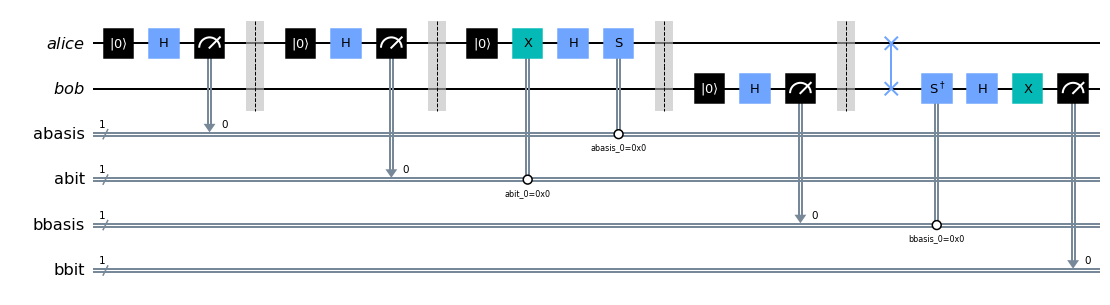

In [5]:
# STEP 1: We initialize our registers. We use two qubits and four classical bits

alice = QuantumRegister(1, 'alice')
bob = QuantumRegister(1, 'bob')
abasis = ClassicalRegister(1, 'abasis')
abit = ClassicalRegister(1, 'abit')
bbasis = ClassicalRegister(1, 'bbasis')
bbit = ClassicalRegister(1, 'bbit')
qkd = QuantumCircuit(alice, bob, abasis, abit, bbasis, bbit)

# STEP 2: Alice chooses a basis randomly
random(qkd, alice[0], abasis[0])

# STEP 3: Alice chooses whether she sends 0 or 1 by random
random(qkd, alice[0], abit[0])

# STEP 4: Alice prepares the state for sending it to Bob
prepare(qkd, alice[0], abit[0], abasis[0])

# STEP 5: Bob chooses the basis for measurement and 'receives' the qubit from Alice via quantum channel
random(qkd, bob[0], bbasis[0])
qkd.swap(alice[0], bob[0])

# STEP 6: Finally, Bob performs the measurement, depending, on
measure(qkd, bob[0], bbit[0], bbasis[0])

qkd.draw('mpl')

Agora Alice e Bob repetem seu processo de medição por 1024 vezes. Vamos simular isto executando nosso circuito quântico 1024 vezes com a ajuda do backend da Aer. Em seguida, estaremos extraindo os bitstrings representando as respectivas escolhas de base (0 ou 1 base) de Alice e Bob e suas respectivas medidas.

In [6]:
aer_sim = Aer.get_backend('aer_simulator') # we load the simulator backend

key_length = 1024 # let's create a 1024 bits long key

# these strings are gonna be the bitstrings representing Alice's and Bob's basis choices as well as their raw keys
abasis = "" 
abit = ""
bbasis = ""
bbit = ""

# run the algorithm 1024 times
for i in range(0, int(key_length)):
    results = aer_sim.run(qkd, shots=1).result()
    counts = results.get_counts()
    res = list(counts.keys())[0]
    abasis += res[6]
    abit += res[4]
    bbasis += res[2]
    bbit += res[0]


Por exemplo, Alice recuperou este bitstring:

In [7]:
abit

'011000100100101110101010111111100111101010000011111010000111100100110001101001000101100001011110111001001101000010111110101001000011000100110100111001101010000001010110001011010100100000010000101001101000010100100011101101000111011111101011110111111100101011101111001100101011001011011000100110010111100000000011011110101010001000101010111110000000010100100100011010011000011100010011110100100000101111111011000010001001011110110100100011000110101010010001010011010100001110110000011000101101100111010111101011001100100001100110101000000000010101111011000001111101100000100101111000000000010010011010010001100111101001110010000110010100101111011110110111101111111110010101111100101110101001101111011101010100000101110010111101010111000111000101101110010100111000000100010010100111011101011100110011011001011000011001100011011101100010001110011111010000000000001100010101011100011101001101000100010110010101010010101001001001100101000100110001010100111111011001111010001001010001111111011111000110101

E Bob recuperou este aqui:

In [8]:
bbit

'101111100100101110101001011110101110101000001111111100000111100100000000101001010000000001011111101001001100000011111100101101100011001000111000111001101001010101010101001111010000010000010100111011100010011110110111111101011101001011101111110011111110000110011011101111100011000111010000000000010011100101000011111110101010000100001001011110000000000111100101011011011100001000101011010000110000111101111010100111101001010111101100001000110110101111000000010111010100000100010000011000101111111111000101101101011100000001100111101000000110001000011110000001011101100111010101111101000000000010011110100001100100001001110000100010100000101111001011110111101110111100010101110010101001001101101101110101010000000000100110001011110110110111001101101110011100110010000100110010000001111111110000100001010100111000001101110001111111110010111110011111010100000100001101000101011100001000001111010101000110011100110111000001001000101001011100111000000101101001011101010110100001010001011111001111101110111

In [9]:
abit == bbit

False

Note que ambos os bitstrings são **não*** o mesmo!

Em seguida, queremos nos dedicar ao pós-processamento. É claro, Alice e Bob às vezes escolhem acidentalmente uma base diferente e podem assim medir um resultado diferente. Esta é a razão pela qual, neste ponto, suas chaves não coincidem. Portanto, Bob e Alice têm que comparar suas escolhas de base e ignorar todas as medidas em que não escolheram a mesma base.

Este processo é chamado de **key sifting*** e é essencial para a implementação do BB84. Sem ele, todo o protocolo falha.

<div class="alert alert-block alert-success">
<b>Part 2</b>
    
Agora, vamos implementar a key sifting. Basicamente, iterar sobre cada medida e descartar cada pedaço para o qual a base que Alice e Bob escolheram independentemente não corresponde. A função 'sifted_key_positions' deve retornar uma lista de todas as peças de medidas utilizáveis.
    
</div>

In [10]:
def sifted_key_positions(abasis, bbasis):
    pos = []
    for i in range(0, len(abasis)):
        if abasis[i] == bbasis[i]:
                pos.append(i)
    return pos

In [11]:
# now let's check whether Bob's key matches Alice's!

sifted_key_alice = "".join([abit[j] for j in sifted_key_positions(abasis, bbasis)])
sifted_key_bob = "".join([bbit[j] for j in sifted_key_positions(abasis, bbasis)])

sifted_key_alice == sifted_key_bob

True

No caso de isto retornar "Verdadeiro": **BB84 foi implementado com sucesso!** 

Infelizmente, _a vida real_ não funciona assim. Vamos agora introduzir algum ruído ao algoritmo quântico. Basta lembrar, por um momento, que todo sistema mecânico quântico é propenso a ruídos. Vamos fazer o mesmo circuito, mas agora em uma máquina _real_.

In [12]:
backend = provider.get_backend('ibmq_santiago')
aer_sim = AerSimulator.from_backend(backend)

key_length = 1024

abasis = ""
abit = ""
bbasis = ""
bbit = ""randomly

for i in range(0, int(key_length)):
    results = aer_sim.run(qkd, shots=1).result()
    counts = results.get_counts()
    res = list(counts.keys())[0]
    abasis += res[6]
    abit += res[4]
    bbasis += res[2]
    bbit += res[0]
    
n_sifted_key_alice = "".join([abit[j] for j in sifted_key_positions(abasis, bbasis)])
n_sifted_key_bob = "".join([bbit[j] for j in sifted_key_positions(abasis, bbasis)])

print(n_sifted_key_alice == n_sifted_key_bob)

False


Maldição! Alice e Bob não têm a mesma chave.

Mas em que exatamente eles diferem?

<div class="alert alert-block alert-success">
<b>Part 3</b>
    
Vamos calcular a taxa de erro de bit quantum (QBER). Ela é definida como a taxa de erros na chave. Você pode calculá-la contando o número de erros e depois dividindo pelo comprimento da chave.
    
</div>

In [13]:
def qber(key_a, key_b):
    errors = 0
    n = len(key_a)
    for i in range(n):
        if(key_a[i] != key_b[i]):
            errors += 1
    return errors/n

qber(n_sifted_key_alice, n_sifted_key_bob)

0.01818181818181818

Em nosso caso, a taxa de erro de bit quântico deve ser um pouco inferior a 7%. Uma implementação completa do BB84 também incluiria um algoritmo de correção de erros. Não vamos lá durante esta palestra. Você não tem que se preocupar com isso _ por enquanto_. Em vez disso, como o objetivo da distribuição de chaves quânticas é estabelecer a segurança, vamos verificar o que acontece com nosso sistema quântico, caso haja um espião, Eve, tentando espionar a _conversão quântica de Alice e Bob_. Modificamos um pouco nosso circuito quântico:

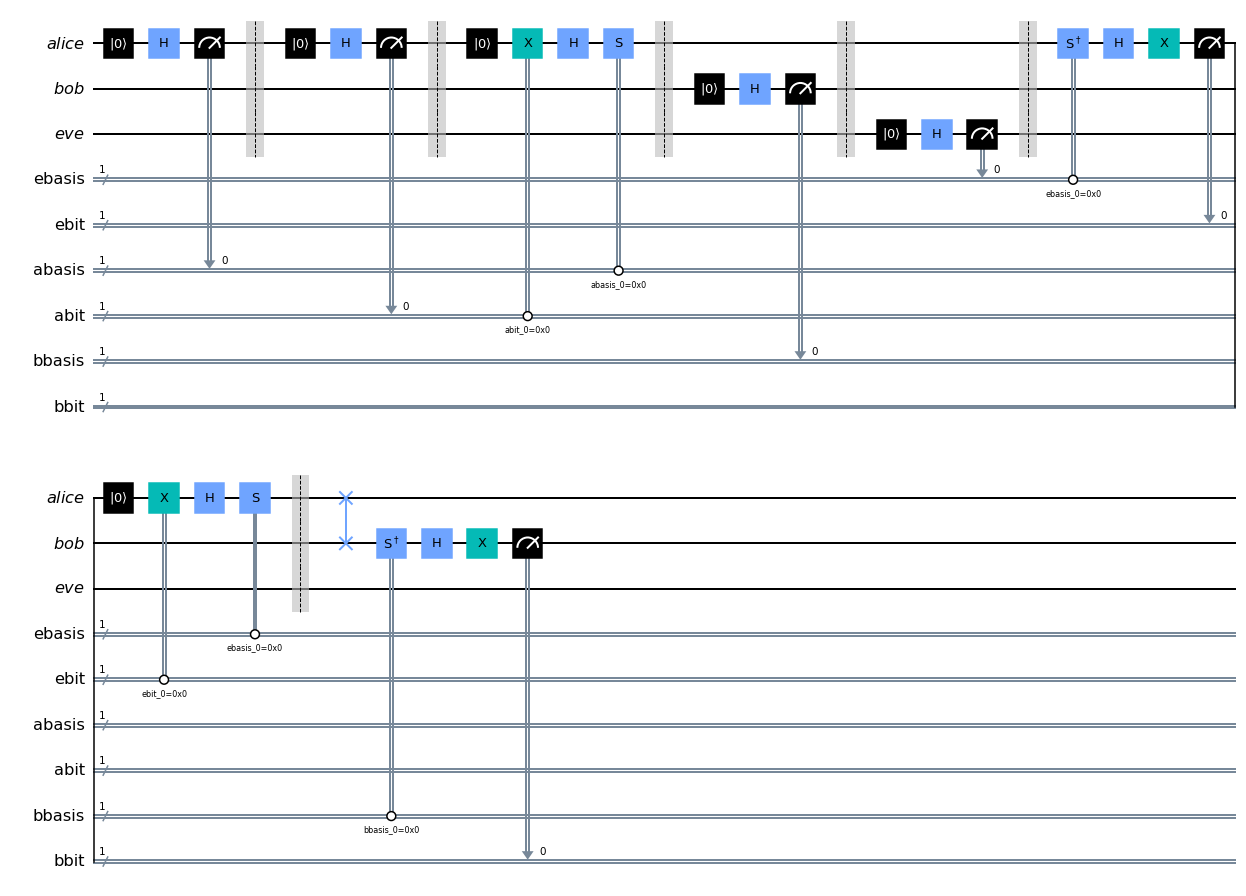

In [14]:
def eavesdropping(circ, q, qbasis, cbit, cbasis):
    random(qkd, qbasis, cbasis) # Eve will chose a basis for measuring the qubit randomly
    measure(qkd, q, cbit, cbasis) # next she measures it
    prepare(qkd, q, cbit, cbasis) # and then she prepares a new qubit so Bob will not be suspicious of her actions
    

# STEP 1: We initialize our registers. We use two qubits and four classical bits for Alice and Bob
# Add a qubit and two classical bits for Eve

alice = QuantumRegister(1, 'alice')
bob = QuantumRegister(1, 'bob')
eve = QuantumRegister(1, 'eve')

abasis = ClassicalRegister(1, 'abasis')
abit = ClassicalRegister(1, 'abit')
bbasis = ClassicalRegister(1, 'bbasis')
bbit = ClassicalRegister(1, 'bbit')
ebasis = ClassicalRegister(1, 'ebasis')
ebit = ClassicalRegister(1, 'ebit')

qkd = QuantumCircuit(alice, bob, eve, ebasis, ebit, abasis, abit, bbasis, bbit)

# STEP 2: Alice chooses a basis randomly
random(qkd, alice[0], abasis[0])

# STEP 3: Alice chooses whether she sends 0 or 1 by random
random(qkd, alice[0], abit[0])

# STEP 4: Alice prepares the state for sending it to Bob
prepare(qkd, alice[0], abit[0], abasis[0])

# STEP 5: Bob chooses the basis for measurement and 'receives' the qubit from Alice via quantum channel
random(qkd, bob[0], bbasis[0])

# STEP 5.5: Eve tries to get as much information as possible by intercepting every qubit, measuring it in a random basis
# and preparing a new qubit for Bob
eavesdropping(qkd, alice[0], eve[0], ebit[0], ebasis[0])

qkd.swap(alice[0], bob[0])

# STEP 6: Finally, Bob performs the measurement, depending, on
measure(qkd, bob[0], bbit[0], bbasis[0])

qkd.draw('mpl')

Ótimo! Eve vai ler informações do canal quântico, mas o que acontece agora? Vamos dar uma olhada. Mas, em nome da demonstração, removeremos qualquer outro ruído, simulando assim novamente um sistema ideal.

In [15]:
aer_sim = Aer.get_backend('aer_simulator') 

key_length = 2**11

abasis = ""
abit = ""
bbasis = ""
bbit = ""
ebasis = ""
ebit = ""

for i in range(0, int(key_length)):
    results = execute(qkd, aer_sim, shots=1).result()
    counts = results.get_counts()
    res = list(counts.keys())[0]
    ebasis += res[10]
    ebit += res[8]
    abasis += res[6]
    abit += res[4]
    bbasis += res[2]
    bbit += res[0]

print(counts)

{'1 1 1 1 1 0': 1}


In [16]:
ne_sifted_key_alice = "".join([abit[j] for j in sifted_key_positions(abasis, bbasis)])
ne_sifted_key_bob = "".join([bbit[j] for j in sifted_key_positions(abasis, bbasis)])

# Eve will have to stick with the basis choices of Alice and Bob
ne_sifted_key_eve = "".join([ebit[j] for j in sifted_key_positions(abasis, bbasis)])

print(f"Quantum bit error rate of Bob: {qber(ne_sifted_key_alice, ne_sifted_key_bob)*100:.2f}%")
print(f"Amount of information Eve was able to snoop on: {(1-qber(ne_sifted_key_alice, ne_sifted_key_eve))*100:.2f}%")

Quantum bit error rate of Bob: 26.30%
Amount of information Eve was able to snoop on: 73.90%


Observamos que Eva foi capaz de ler uma quantidade significativa da chave! Na verdade, ela tem aproximadamente o mesmo nível de conhecimento dos números de Alice que Bob. Isto significa que um pós-processamento seguro não pode ser feito. Alice e Bob não devem usar esta chave quântica! Felizmente, também observamos que a taxa de erro de bit quântico de Bob aumentou para cerca de 25%. Esta é outra vantagem da distribuição da chave quântica: os ataques podem ser notados por Alice e Bob.